How should we handle a stochastic model? In computing the sensitivity measures, is it sufficient to run the model *once* for each sample parameter set, should we use an average over many runs for each sample parameter set, or maybe even just a few runs for each parameter set?

# Persistence time of a general epidemic

The stochastic general epidemic model with counts $(S, I, R)$ of the number of people susceptible, infectious, and recovered, has events:

* Birth: $(S, I, R) \to (S + 1, I, R)$ with hazard $\mu N$;
* Death of a susceptible: $(S, I, R) \to (S - 1, I, R)$ with hazard $\mu S$;
* Death of an infectious: $(S, I, R) \to (S, I - 1, R)$ with hazard $\mu I$;
* Death of a recovered: $(S, I, R) \to (S, I, R - 1)$ with hazard $\mu R$;
* Infection: $(S, I, R) \to (S - 1, I + 1, R)$ with hazard $\frac{\beta I}{N} S$; and
* Recovery: $(S, I, R) \to (S, I - 1, R + 1)$ with hazard $\gamma I$;

where $N = S + I + R$.

The basic reproduction number is
$$R_0 = \frac{\beta}{\gamma + \mu}.$$

When $R_0 > 1$, we will use the endemic equilibrium of the deterministic model
$$\begin{aligned}
\frac{\mathrm{d} S}{\mathrm{d} t} &= \mu N - \frac{\beta I}{N} S - \mu S,\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \frac{\beta I}{N} S - \gamma I - \mu I,\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma I - \mu R,
\end{aligned}$$
as the expected value of a multinomial distribution to determine the initial condition for the stochastic model:
$$\left(S(0), I(0), R(0)\right)
= \mathrm{Multinomial}(N_0, p),$$
where
$$p = \left(\frac{1}{R_0},
            \frac{\mu}{\beta}\left(R_0 - 1\right),
            \frac{\gamma}{\beta}\left(R_0 - 1\right)\right),$$
and $N_0$ is the initial population size.
We will resample from this multinomial until we get an initial condition with $I(0) > 0$.

We will simulate the stochastic model using the Gillespie algorithm.

For each simulation, we will find the extinction time, the first time with $I(t) = 0$.

In [1]:
import lifelines
import numpy
import pandas
from scipy import stats

import sensitivity_analysis
import persistence

In [2]:
persistence.get_persistence_time(0.012, 0.01, 0.001, seed=1)

2171.1930732740902

Let's take the parameters to be the random variables
$$\begin{aligned}
\beta &\sim \Gamma(0.03, 4),\\
\gamma &\sim \Gamma(0.01, 4),\\
\mu &\sim \Gamma(0.001, 4),
\end{aligned}$$
where $\Gamma(a, k)$ is the gamma random variable with mean $a$ and shape $k$.

In [3]:
parameters = persistence.get_parameters()

In [4]:
# n_samples = 1000
# seed_seq = numpy.random.SeedSequence(1)
# samples = sensitivity_analysis.samples_Latin_hypercube(parameters,
#                                                        n_samples=n_samples,
#                                                        seed=persistence.get_seed(seed_seq))
# persistence_times = persistence.run_many(persistence.get_persistence_time,
#                                          samples,
#                                          seed=persistence.get_seed(seed_seq))

samples = pandas.DataFrame(numpy.load('samples.npy'),
                           columns=parameters.keys())
persistence_times = numpy.load('persistence.npy')

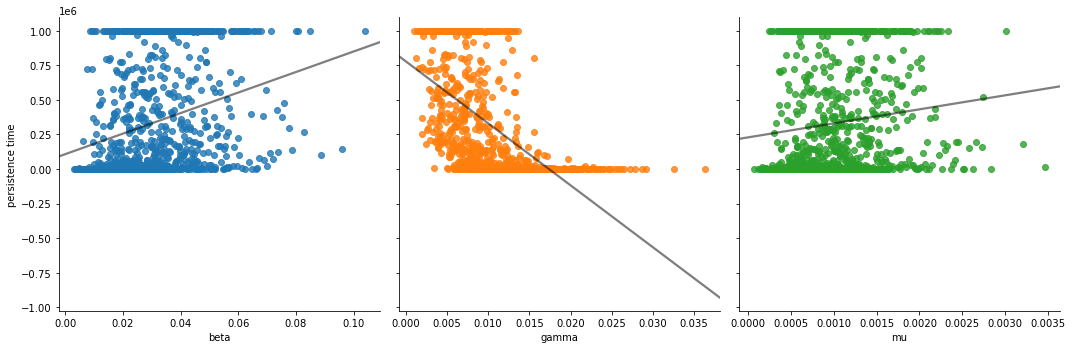

In [5]:
fg = sensitivity_analysis.scatterplots_samples(samples, persistence_times)
_ = fg.set_ylabels('persistence time')

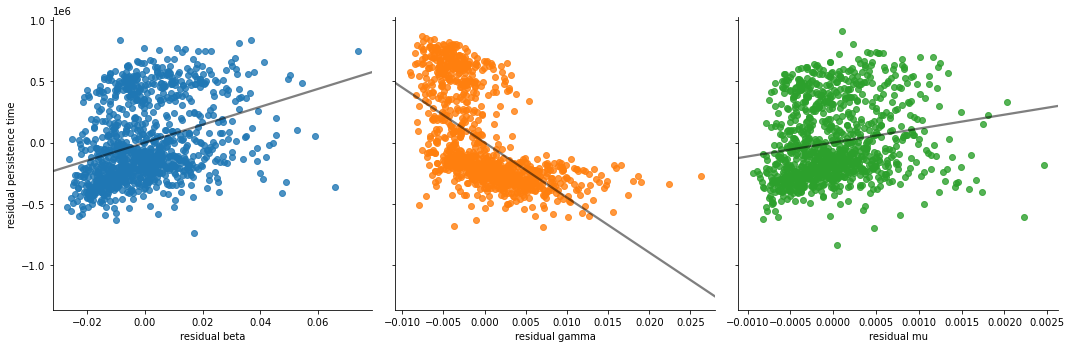

In [6]:
fg = sensitivity_analysis.residualplots_samples(samples, persistence_times)
_ = fg.set_ylabels('residual persistence time')

In [7]:
table = {}
table[r'$\beta_{\sigma}$'] = sensitivity_analysis.linreg_coefficients_samples(
    samples, persistence_times)
table[r'$\rho_{\mathrm{partial\ rank}}$'] = sensitivity_analysis.PRCC_samples(
    samples, persistence_times)
table = pandas.DataFrame(table)
table

,$\beta_{\sigma}$,$\rho_{\mathrm{partial\ rank}}$
beta,0.271570,0.593417
gamma,-0.558029,-0.788616
mu,0.141260,0.333568


In [8]:
# Format input and output for `lifeines`.
df = samples.copy()
df['duration'] = persistence_times
# Extinction was observed if the persistence time is less than 1e6.
df['event'] = (df['duration'] <= 1e6)
# Drop simulations that started extinct, i.e. R_0 < 1.
# df = df[df['duration'] > 0]

/home/medlock/.local/lib/python3.8/site-packages/lifelines/utils/__init__.py:1079: ConvergenceWarning: Column(s) ['gamma', 'mu'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 1000 total observations, 205 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 795
   partial log-likelihood = -4522.72
         time fit was run = 2020-08-11 00:57:12 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
beta       -56.59       0.00       3.36           -63.18           -50.01                 0.00                 0.00
gamma      272.06  1.42e+118       8.66           255.08           289.03            6.04e+110            3.34e+125
mu        -865.52       0.00      87.91         -1037.82          -693.22                 0.00                 0.00
               z      p   -log2(p)
covariate                         
beta      -16.85 <0.005     209.28
gamma      31.42 <0.005     717.22
mu         -9.85 <0.005      73.57
---
Concordance = 0.84
Partial AIC = 9051.44
log-likelihood ratio test = 999.22 on 3 df
-log2(p) of ll-ratio test = 716.13

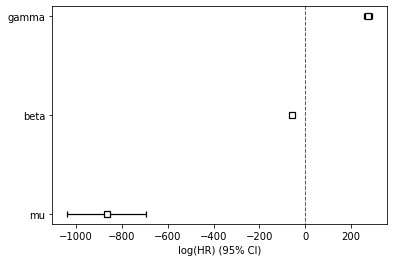

In [9]:
cph = lifelines.CoxPHFitter()
cph.fit(df, duration_col='duration', event_col='event')
cph.plot()
cph.print_summary()

In [10]:
# The regression coefficients.
beta_CPH = cph.summary['coef']
beta_CPH

covariate
beta     -56.594598
gamma    272.055108
mu      -865.519700
Name: coef, dtype: float64

In [11]:
# The regression coefficients scaled by the standard deviations.
beta_CPH_sigma = beta_CPH * samples.std(ddof=1) / numpy.std(persistence_times, ddof=1)
beta_CPH_sigma

covariate
beta    -0.000002
gamma    0.000003
mu      -0.000001
dtype: float64

<lifelines.AalenAdditiveFitter: fitted with 1000 total observations, 205 right-censored observations>
             duration col = 'duration'
                event col = 'event'
       number of subjects = 1000
number of events observed = 795
         time fit was run = 2020-08-11 00:57:13 UTC

---
Empty DataFrame
Columns: []
Index: [beta, gamma, mu, Intercept]
---
Concordance = 0.83

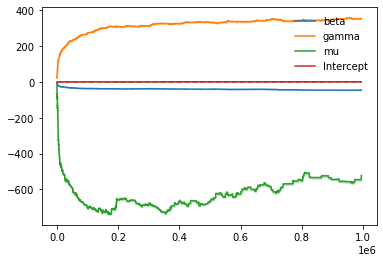

In [12]:
aaf = lifelines.AalenAdditiveFitter()
aaf.fit(df, duration_col='duration', event_col='event')
aaf.plot()
aaf.print_summary()

In [13]:
# The regression coefficients.
beta_AAF = aaf.summary['slope(coef)'].drop('Intercept')
beta_AAF

covariate
beta    -0.000203
gamma    0.001497
mu      -0.003220
Name: slope(coef), dtype: float64

In [14]:
# The regression coefficients scaled by the standard deviations.
beta_AAF_sigma = beta_AAF * samples.std(ddof=1) / numpy.std(persistence_times, ddof=1)
beta_AAF_sigma

covariate
beta    -7.593383e-12
gamma    1.866300e-11
mu      -4.008222e-12
dtype: float64